In [7]:
## Standard libraries
import math
import numpy as np
from pathlib import Path
import random

## Imports for plotting
from matplotlib import pyplot as plt

## Progress bar
#from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.optim as optim


from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

import pennylane as qml


In [8]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(324)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [9]:
print(torch.__version__)  # Check the installed version of PyTorch
print(torch.cuda.is_available())  # Check if GPU is available


2.0.0+cu118
True


# DATA GENERATION

In [ ]:
def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 4, #2
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return V#out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")

    Norig = len(gw["data"][0]) #signal length

    Ndat = len(gw["signal_present"]) #gw["signal_present"] if signal is present (number of signals)
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        
        #ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        #Rcoeflist.append(Rcoef[j % n_snr_values])
        R = random.sample(list(Rcoef),1)[0] ##
        ncoeff.append(10 ** (-19) * (1 / R)) ##
        Rcoeflist.append(R) ##
        
    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)
    l = list(np.concatenate([np.ones(int(n_signals/2)), np.zeros(n_signals - int(n_signals/2))])) #
    #print(l)
    l = random.sample(l, len(l)) #
    #print(l)
    for j in range(n_signals):
        #move the signal in the noise
        rand_roll = np.random.randint(1500)
        #signal = np.roll(gw["data"][j % Ndat][range(0, Norig, downsample_factor)], rand_roll)
        #signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        signal = np.roll(gw["data"][random.sample(list(np.arange(0,11)),1)[0]][range(0, Norig, downsample_factor)], rand_roll)

        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        #labels[j] = sigp
        labels[j] = l[j]
        #if sigp == 1:
        if l[j] == 1.:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)
    return noisy_signals, gw_signals, labels, Rcoeflist

In [ ]:
from pathlib import Path

R = 0.075
R_min = 0.075
R_max = 0.65
n_signals = 3500
DATA = Path("./")

noisy_signals, gw_signals, labels, Rs = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R_min, r_max=R_max, n_snr_values=10
)
SNRs = 27.54*np.array(Rs)+0.064
print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

In [10]:
#OR IMPORT ALREADY SAVED SIGNALS
noisy_signals = torch.load('noisy_signals.pt')
gw_signals = torch.load('gw_signals.pt')
labels = torch.load('labels.pt')
SNRs = torch.load('SNRs.pt')

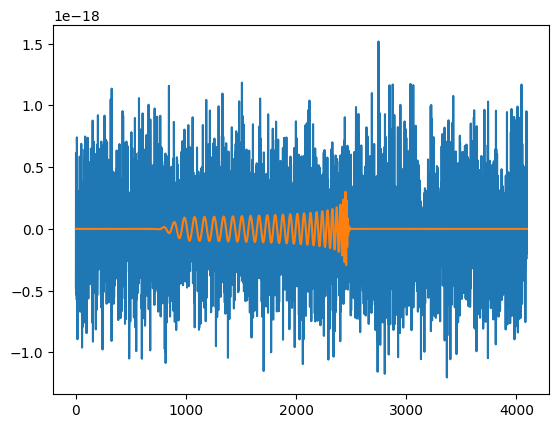

In [11]:
from matplotlib import pyplot as plt
i=0

plt.plot(noisy_signals[i])
plt.plot(gw_signals[i])
plt.show()

# TOPOLOGICAL FEATURES

In [12]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

from sklearn.decomposition import PCA

# Normalize the data
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split

import torch.nn.functional as F


In [13]:
#Function that creates topological features given the signals. First performs sliding window embedding 
#Then computes the percistane diagram and from this diagram we get the topological features
def create_topological(noisy_signals):
   
    embedding_dimension = 200
    embedding_time_delay = 10
    stride = 5

    embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)

    batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

    persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

    scaling = Scaler()

    entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)


    steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling)]#,#]#
         #("entropy", entropy)]
    topological_transfomer = Pipeline(steps)

    features = topological_transfomer.fit_transform(noisy_signals)
    #features = topological_transfomer.fit_transform(noisy_signals)

    P = []
    for signal in features:
        H0 = signal[:,2]==0.
        H1 = signal[:,2]==1.
        l0 = signal[H0].shape[0]
        l1 = signal[H1].shape[0]
        if l1>l0:
            dif = l1-l0
            P0 = torch.tensor(signal[H0][:,1]-signal[H0][:,0])
            P0 = torch.sort(F.pad(P0, (0,dif), "constant", 0), descending= True)[0]
            P1 = torch.sort(torch.tensor(signal[H1][:,1]-signal[H1][:,0]),  descending= True)[0]
            P.append(torch.cat([P0, P1]))
            #print(P0.shape, P1.shape)

        else:
            dif = l0-l1
            P0 = torch.sort(torch.tensor(signal[H0][:,1]-signal[H0][:,0]), descending= True)[0]
            P1 = torch.tensor(signal[H1][:,1]-signal[H1][:,0])
            P1 = torch.sort(F.pad(P1, (0,dif), "constant", 0), descending = True)[0]
            P.append(torch.cat([P0, P1]))
            #print(P0.shape, P1.shape)



  #print((signal[H0][:,1]-signal[H0][:,0]).shape)
  #P.append(torch.cat([torch.tensor(signal[H0][:,1]-signal[H0][:,0]),torch.tensor(signal[H1][:,1]-signal[H1][:,0])]))
#  break
    topological_P = torch.stack(P)
    return topological_P

In [14]:
#Creates dataloaders for training
def create_loaders(noisy_signals, labels, SNRs, batch_size=32,random_seed = 42 , top = 1):

    #Normalization
    signal_data = torch.tensor(noisy_signals)
    scaler = StandardScaler()
    scaler2 = MinMaxScaler()
    scaler3 = MaxAbsScaler()
    X = torch.tensor(scaler.fit_transform(signal_data))
    labelss = torch.cat([torch.tensor(labels).view(-1,1), torch.tensor(SNRs).view(-1,1)], dim=1 )

    if top:
        features = create_topological(noisy_signals)
        X_top = torch.tensor(scaler2.fit_transform(torch.tensor(features)))
        X = torch.cat([X, X_top], dim=1 )
  

    X_train, X_test, y_train, y_test = train_test_split(X, labelss, test_size=0.4, stratify=torch.tensor(labelss[:,0]), random_state=42)
    # Further split the training set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=torch.tensor(y_train[:,0]), random_state=42)
    print("total data: ", X.shape[0])
    print("test: ",X_train.shape[0], "val: ", X_val.shape[0], "test:", X_test.shape[0])
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    input_size = X.shape[1]
    
    return input_size, train_loader, val_loader, test_loader

In [15]:
#Neural network


# Define the 1D CNN model
class TimeSeriesCNN(nn.Module):
    def __init__(self, output = 1):
        super(TimeSeriesCNN, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=16, stride=1),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=16, stride=1),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=16, stride=1),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=32, stride=1),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.ReLU(),
            nn.Flatten()
        )
        
        


    def forward(self, x):
        x = self.conv_net(x)

        return x


class HybridModel(nn.Module):
    def __init__(self, Quantum = True, input_size = 4096,type =1, n_layers=1):
        super(HybridModel, self).__init__()
        self.type = type
        self.input_size = input_size
        if self.type==1:
            self.n_qubits = 7
        else:
            self.n_qubits = 6
        self.Quantum = Quantum
        
        weight_shapes = {"weights": (n_layers, self.n_qubits)}
        dev = qml.device("default.qubit", wires=self.n_qubits)
        @qml.qnode(dev)
        def qnode(inputs, weights):
            qml.AmplitudeEmbedding(inputs, wires=range(self.n_qubits),normalize=True)
            qml.BasicEntanglerLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.n_qubits)]
        
        self.cnn = TimeSeriesCNN()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.act = nn.Sigmoid()
        self.linear = nn.Linear(self.n_qubits,1)
        
        self.mlp_net = nn.Sequential(
            nn.Linear(self._calculate_fc_input_size(), 128), #3584, 5120, 5632, 11776, 17408
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
        self.mlp_net_type2 = nn.Sequential(
            nn.Linear(self._calculate_fc_input_size(), 128), #3584, 5120, 5632, 11776, 17408
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU()
        )

        self.mlp_net_type1 = nn.Sequential(
            nn.Linear(self._calculate_fc_input_size(), 128), #3584, 5120, 5632, 11776, 17408
            nn.ReLU()
        )
    
    
    
    def _calculate_fc_input_size(self):
        with torch.no_grad():
            input_tensor = torch.zeros(1, 1, self.input_size)
            output = self.cnn(input_tensor)
            print(output.numel())
        return output.numel()
    
    def forward(self, x):

        x = self.cnn(x)
        if self.Quantum:
            if self.type == 1:
                x = self.mlp_net_type1(x)
                x = self.qlayer(x)
                x = self.act(self.linear(x.double()))  # Apply sigmoid activation for binary classification
            else:
                x = self.mlp_net_type2(x)
                #print(x.shape, self.n_qubits)
                x=self.qlayer(x)
                x=self.act(self.linear(x.double()))
        else:
          x = self.mlp_net(x)

        return x.double()
    


In [16]:

#Function for Training the model

import copy

def training(runs=15, num_epochs=40, learning_rate = 1e-3, model_=HybridModel(Quantum=False), str = 'cnn', train_loader=None, val_loader=None, test_loader=None):

# Parameters

    loss_mat = np.zeros([runs, num_epochs])
    acc_mat = np.zeros([runs, num_epochs])
    val_loss_mat = np.zeros([runs, num_epochs])
    val_acc_mat = np.zeros([runs, num_epochs])
    eval_mat = np.zeros(runs)
    criterion = nn.BCELoss()

    # Instantiate the model, loss function, and optimizer
    for run in range(0, runs):
        model = copy.deepcopy(model_)
        model.double()
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        best_val_accuracy = 0.0  # Variable to track the best validation accuracy for this run
        best_model_path = f'models/main/best_model_run_{run+1}_{str}.pth'  # File path to save the best model for each run

        print("Run", run)

        # Training loop
        for epoch in range(num_epochs):
            correct = 0
            total = 0
            model.train()
            running_loss = 0.0
            for i, (inputs, label) in enumerate(train_loader):
                label = label[:,0]
                inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 1).double(), label.view(-1, 1).to(device))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted.to('cpu') == label.view_as(predicted.to('cpu'))).sum().item()
                total += label.size(0)
        
            loss_mat[run, epoch] = running_loss / len(train_loader)
            acc_mat[run, epoch] = 100 * correct / total
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Acc: {100 * correct / total}')

            # Validation
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, label in val_loader:
                    label = label[:,0]
                    inputs = inputs.unsqueeze(1).to(device)
                    outputs = model(inputs)
                    val_loss = criterion(outputs.view(-1, 1).double(), label.view(-1, 1).to(device))
                    val_running_loss += val_loss.item()
                    predicted = (outputs > 0.5).float()
                    val_correct += (predicted.to('cpu') == label.view_as(predicted.to('cpu'))).sum().item()
                    val_total += label.size(0)
        
            val_loss_mat[run, epoch] = val_running_loss / len(val_loader)
            val_acc_mat[run, epoch] = 100 * val_correct / val_total
            val_accuracy = 100 * val_correct / val_total
            print(f'Validation Loss: {val_running_loss/len(val_loader)}, Validation Acc: {100 * val_correct / val_total}')
            # Save the model if validation accuracy is the best we've seen so far
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), best_model_path)
                print(f'Saved the best model with validation accuracy: {val_accuracy:.2f}%')
    
        # Final Test Evaluation after Training
        model.load_state_dict(torch.load(best_model_path))  # Load the best model

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, label in test_loader:
                label = label[:,0]
                inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                correct += (predicted.to('cpu') == label.view_as(predicted.to('cpu'))).sum().item()
                total += label.size(0)
    
        eval_mat[run] = 100 * correct / total
        print(f'Final Test Accuracy: {100 * correct / total:.2f}%')


    return loss_mat, acc_mat, val_loss_mat, val_acc_mat, eval_mat

3584
3584
3584


# RAW SIGNAL

In [22]:
#create data set without topological features
input_size, train_loader, val_loader, test_loader = create_loaders(labels=labels, SNRs=SNRs, noisy_signals=noisy_signals ,top = 0)


total data:  3500
test:  1575 val:  525 test: 1400


C:\Users\Computing\AppData\Local\Temp\ipykernel_26160\134482116.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_test, y_train, y_test = train_test_split(X, labelss, test_size=0.4, stratify=torch.tensor(labelss[:,0]), random_state=42)
C:\Users\Computing\AppData\Local\Temp\ipykernel_26160\134482116.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=torch.tensor(y_train[:,0]), random_state=42)


In [12]:
#CNN
model_cnn = HybridModel(Quantum=False, input_size= input_size, type=1)
loss_cnn, acc_cnn, val_loss_cnn, val_acc_cnn, eval_cnn = training(model_ = model_cnn ,train_loader=train_loader, val_loader=val_loader, test_loader= test_loader)
torch.save(loss_cnn, 'data_tensors/main/loss_cnn.pt')
torch.save(acc_cnn, 'data_tensors/main/acc_cnn.pt')
torch.save(val_loss_cnn, 'data_tensors/main/val_loss_cnn.pt')
torch.save(val_acc_cnn, 'data_tensors/main/val_acc_cnn.pt')
torch.save(eval_cnn, 'data_tensors/main/eval_cnn.pt')

3584
3584
3584
Using 2 GPUs!
Run 0
Epoch 1/40, Loss: 0.7046910867250274, Acc: 54.22222222222222
Validation Loss: 0.719927068275381, Validation Acc: 49.142857142857146
Saved the best model with validation accuracy: 49.14%
Epoch 2/40, Loss: 0.5889877442221717, Acc: 71.11111111111111
Validation Loss: 0.5597515638483359, Validation Acc: 69.52380952380952
Saved the best model with validation accuracy: 69.52%
Epoch 3/40, Loss: 0.41208935809303143, Acc: 79.17460317460318
Validation Loss: 0.41039589964904283, Validation Acc: 77.14285714285714
Saved the best model with validation accuracy: 77.14%
Epoch 4/40, Loss: 0.38388828791343604, Acc: 80.12698412698413
Validation Loss: 0.3922931228135236, Validation Acc: 81.14285714285714
Saved the best model with validation accuracy: 81.14%
Epoch 5/40, Loss: 0.37411376395319307, Acc: 80.57142857142857
Validation Loss: 0.36037718902253824, Validation Acc: 80.76190476190476
Epoch 6/40, Loss: 0.37723967475085596, Acc: 79.80952380952381
Validation Loss: 0.754

In [15]:
#HCNN1
model_hcnn1 = HybridModel(Quantum=True, input_size= input_size, type=1, n_layers=2)
loss_hcnn1, acc_hcnn1, val_loss_hcnn1, val_acc_hcnn1, eval_hcnn1 = training(model_ = model_hcnn1, train_loader=train_loader, val_loader=val_loader, test_loader= test_loader, str='hcnn1')
torch.save(loss_hcnn1, 'data_tensors/main/loss_hcnn1.pt')
torch.save(acc_hcnn1, 'data_tensors/main/acc_hcnn1.pt')
torch.save(val_loss_hcnn1, 'data_tensors/main/val_loss_hcnn1.pt')
torch.save(val_acc_hcnn1, 'data_tensors/main/val_acc_hcnn1.pt')
torch.save(eval_hcnn1, 'data_tensors/main/eval_hcnn1.pt')

3584
3584
3584
Using 2 GPUs!
Run 0
Epoch 1/40, Loss: 0.6959387980506183, Acc: 49.07936507936508
Validation Loss: 0.6931163276288423, Validation Acc: 50.476190476190474
Saved the best model with validation accuracy: 50.48%
Epoch 2/40, Loss: 0.6803152158127952, Acc: 58.285714285714285
Validation Loss: 0.7010350571465346, Validation Acc: 49.904761904761905
Epoch 3/40, Loss: 0.6224425541114368, Acc: 72.76190476190476
Validation Loss: 0.7091044646220305, Validation Acc: 50.857142857142854
Saved the best model with validation accuracy: 50.86%
Epoch 4/40, Loss: 0.5749806519755525, Acc: 77.26984126984127
Validation Loss: 0.5575235273539337, Validation Acc: 77.33333333333333
Saved the best model with validation accuracy: 77.33%
Epoch 5/40, Loss: 0.5280699815776081, Acc: 81.01587301587301
Validation Loss: 0.5354528179967318, Validation Acc: 77.33333333333333
Epoch 6/40, Loss: 0.5151860008980137, Acc: 79.87301587301587
Validation Loss: 0.5231063984832786, Validation Acc: 77.9047619047619
Saved th

In [17]:
#HCNN2
model_hcnn2 = HybridModel(Quantum=True, input_size= input_size, type=2)
loss_hcnn2, acc_hcnn2, val_loss_hcnn2, val_acc_hcnn2, eval_hcnn2 = training(model_ = model_hcnn2, train_loader=train_loader, val_loader=val_loader, test_loader= test_loader, str='hcnn2')
torch.save(loss_hcnn2, 'data_tensors/main/loss_hcnn2.pt')
torch.save(acc_hcnn2, 'data_tensors/main/acc_hcnn2.pt')
torch.save(val_loss_hcnn2, 'data_tensors/main/val_loss_hcnn2.pt')
torch.save(val_acc_hcnn2, 'data_tensors/main/val_acc_hcnn2.pt')
torch.save(eval_hcnn2, 'data_tensors/main/eval_hcnn2.pt')

3584
3584
3584
Using 2 GPUs!
Run 0
Epoch 1/40, Loss: 0.6957550458856651, Acc: 49.523809523809526
Validation Loss: 0.6935366092514218, Validation Acc: 50.095238095238095
Saved the best model with validation accuracy: 50.10%
Epoch 2/40, Loss: 0.6936045418454115, Acc: 49.96825396825397
Validation Loss: 0.6934959227114341, Validation Acc: 50.095238095238095
Epoch 3/40, Loss: 0.6930403905788612, Acc: 51.42857142857143
Validation Loss: 0.6938067376947517, Validation Acc: 48.95238095238095
Epoch 4/40, Loss: 0.6931426766932944, Acc: 51.55555555555556
Validation Loss: 0.6938743842718025, Validation Acc: 48.95238095238095
Epoch 5/40, Loss: 0.6898722756162162, Acc: 55.111111111111114
Validation Loss: 0.6937358366810724, Validation Acc: 49.142857142857146
Epoch 6/40, Loss: 0.6313076000915157, Acc: 70.73015873015873
Validation Loss: 0.6099236915432416, Validation Acc: 71.04761904761905
Saved the best model with validation accuracy: 71.05%
Epoch 7/40, Loss: 0.5907240598652433, Acc: 73.65079365079364

# RAW SIGNAL + TOPOLOGICAL

In [23]:
#create data set without topological features
input_size_top, train_loader_top, val_loader_top, test_loader_top = create_loaders(labels=labels, SNRs=SNRs, noisy_signals=noisy_signals ,top = 1)


total data:  3500
test:  1575 val:  525 test: 1400


C:\Users\Computing\AppData\Local\Temp\ipykernel_26160\134482116.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_top = torch.tensor(scaler2.fit_transform(torch.tensor(features)))
C:\Users\Computing\AppData\Local\Temp\ipykernel_26160\134482116.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_test, y_train, y_test = train_test_split(X, labelss, test_size=0.4, stratify=torch.tensor(labelss[:,0]), random_state=42)
C:\Users\Computing\AppData\Local\Temp\ipykernel_26160\134482116.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

In [26]:
#CNN
model_cnn_top = HybridModel(Quantum=False, input_size= input_size_top, type=1)
loss_cnn_top, acc_cnn_top, val_loss_cnn_top, val_acc_cnn_top, eval_cnn_top = training(model_ = model_cnn_top ,train_loader=train_loader_top, val_loader=val_loader_top, test_loader= test_loader_top, str = 'cnn_top')
torch.save(loss_cnn_top, 'data_tensors/main/loss_cnn_top.pt')
torch.save(acc_cnn_top, 'data_tensors/main/acc_cnn_top.pt')
torch.save(val_loss_cnn_top, 'data_tensors/main/val_loss_cnn_top.pt')
torch.save(val_acc_cnn_top, 'data_tensors/main/val_acc_cnn_top.pt')
torch.save(eval_cnn_top, 'data_tensors/main/eval_cnn_top.pt')

5120
5120
5120
Using 2 GPUs!
Run 0
Epoch 1/40, Loss: 0.7060089544647767, Acc: 50.92063492063492
Validation Loss: 0.7144571485149559, Validation Acc: 49.904761904761905
Saved the best model with validation accuracy: 49.90%
Epoch 2/40, Loss: 0.5788494177386889, Acc: 70.7936507936508
Validation Loss: 1.0002537754918084, Validation Acc: 50.095238095238095
Saved the best model with validation accuracy: 50.10%
Epoch 3/40, Loss: 0.42991054923043104, Acc: 79.11111111111111
Validation Loss: 1.3680735381537739, Validation Acc: 50.857142857142854
Saved the best model with validation accuracy: 50.86%
Epoch 4/40, Loss: 0.4289496689800278, Acc: 78.66666666666667
Validation Loss: 0.4389031025722491, Validation Acc: 78.0952380952381
Saved the best model with validation accuracy: 78.10%
Epoch 5/40, Loss: 0.35861045255652413, Acc: 80.6984126984127
Validation Loss: 0.7211028474953859, Validation Acc: 66.28571428571429
Epoch 6/40, Loss: 0.37521156397888006, Acc: 82.03174603174604
Validation Loss: 0.432787

In [16]:
#HCNN1
model_hcnn1_top = HybridModel(Quantum=True, input_size= input_size_top, type=1,n_layers=2)
loss_hcnn1_top, acc_hcnn1_top, val_loss_hcnn1_top, val_acc_hcnn1_top, eval_hcnn1_top = training(model_ = model_hcnn1_top, train_loader=train_loader_top, val_loader=val_loader_top, test_loader= test_loader_top, str='hcnn1_top')
torch.save(loss_hcnn1_top, 'data_tensors/main/loss_hcnn1_top.pt')
torch.save(acc_hcnn1_top, 'data_tensors/main/acc_hcnn1_top.pt')
torch.save(val_loss_hcnn1_top, 'data_tensors/main/val_loss_hcnn1_top.pt')
torch.save(val_acc_hcnn1_top, 'data_tensors/main/val_acc_hcnn1_top.pt')
torch.save(eval_hcnn1_top, 'data_tensors/main/eval_hcnn1_top.pt')

5120
5120
5120
Using 2 GPUs!
Run 0
Epoch 1/40, Loss: 0.6956246569173663, Acc: 48.19047619047619
Validation Loss: 0.693853457774549, Validation Acc: 50.285714285714285
Saved the best model with validation accuracy: 50.29%
Epoch 2/40, Loss: 0.690528434770073, Acc: 52.317460317460316
Validation Loss: 0.6800721969905273, Validation Acc: 56.76190476190476
Saved the best model with validation accuracy: 56.76%
Epoch 3/40, Loss: 0.6489183143630944, Acc: 66.92063492063492
Validation Loss: 0.6577652529128237, Validation Acc: 60.95238095238095
Saved the best model with validation accuracy: 60.95%
Epoch 4/40, Loss: 0.5722602617169504, Acc: 78.85714285714286
Validation Loss: 0.5535986326156667, Validation Acc: 78.66666666666667
Saved the best model with validation accuracy: 78.67%
Epoch 5/40, Loss: 0.5257989933574476, Acc: 81.46031746031746
Validation Loss: 0.6025326629225254, Validation Acc: 68.19047619047619
Epoch 6/40, Loss: 0.49418794534323707, Acc: 82.28571428571429
Validation Loss: 0.47866849

In [18]:
#HCNN2
model_hcnn2_top = HybridModel(Quantum=True, input_size= input_size_top, type=2)
loss_hcnn2_top, acc_hcnn2_top, val_loss_hcnn2_top, val_acc_hcnn2_top, eval_hcnn2_top = training(model_ = model_hcnn2_top, train_loader=train_loader_top, val_loader=val_loader_top, test_loader= test_loader_top, str='hcnn2_top')
torch.save(loss_hcnn2_top, 'data_tensors/main/loss_hcnn2_top.pt')
torch.save(acc_hcnn2_top, 'data_tensors/main/acc_hcnn2_top.pt')
torch.save(val_loss_hcnn2_top, 'data_tensors/main/val_loss_hcnn2_top.pt')
torch.save(val_acc_hcnn2_top, 'data_tensors/main/val_acc_hcnn2_top.pt')
torch.save(eval_hcnn2_top, 'data_tensors/main/eval_hcnn2_top.pt')

5120
5120
5120
Using 2 GPUs!
Run 0
Epoch 1/40, Loss: 0.694913782597023, Acc: 49.523809523809526
Validation Loss: 0.6933415192629461, Validation Acc: 50.476190476190474
Saved the best model with validation accuracy: 50.48%
Epoch 2/40, Loss: 0.6917951354990187, Acc: 51.87301587301587
Validation Loss: 0.6935293240167264, Validation Acc: 49.142857142857146
Epoch 3/40, Loss: 0.6329579051369967, Acc: 71.55555555555556
Validation Loss: 0.6361539225311179, Validation Acc: 63.42857142857143
Saved the best model with validation accuracy: 63.43%
Epoch 4/40, Loss: 0.5693727249628298, Acc: 78.92063492063492
Validation Loss: 0.5714547396859233, Validation Acc: 75.04761904761905
Saved the best model with validation accuracy: 75.05%
Epoch 5/40, Loss: 0.5349190356528, Acc: 79.11111111111111
Validation Loss: 0.5655908013786668, Validation Acc: 73.9047619047619
Epoch 6/40, Loss: 0.4910511241155515, Acc: 81.52380952380952
Validation Loss: 0.8239886748037655, Validation Acc: 50.666666666666664
Epoch 7/40, 

# PLOTS

In [18]:
#Function for ploting losses and accuracies
def plot_loss(losses, variance = 0, title = 'training loss', ylabel='loss', plot_label = ['raw', 'raw+top']):


    for i, loss in enumerate(losses):
        mu = np.mean(loss, 0)
        sigma = np.std(loss,0)
        plt.plot(np.arange(0,40), mu, label =plot_label[i])


        if variance == 1:

            plt.fill_between(np.arange(0,40), mu-sigma, mu+sigma,
            alpha=0.5)

    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid()
    plt.savefig('plots/'+title+'.png', dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
#Function theat computes the average prediction with models for each run
from sklearn.metrics import roc_curve, auc, roc_auc_score
def average_predictions(model, runs =None, str= 'cnn', test_loader = None):
    y_pred = []
    mean_roc = []
    for ind, run in enumerate(runs):
    
        model.double()
        model = model.to(device)
    
        # Load the best model for this run
        best_model_path = f'models/main/best_model_run_{run+1}_{str}.pth'
        model.load_state_dict(torch.load(best_model_path))
        model.eval()
        pred = []
        label_ = []
        SNR = []
        with torch.no_grad():
            for inputs, label in test_loader:
                inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension
                outputs = model(inputs)
                #predicted = (outputs > 0.5).float()
                pred.append(outputs)
                label_.append(label[:,0])
                SNR.append(label[:,1])
        y_pred.append(torch.cat(pred, dim=0).to('cpu').view(-1))
        y_true = torch.cat(label_, dim=0).to('cpu')
        snr_values = torch.cat(SNR, dim=0).to('cpu')
        
        #fpr, tpr, thresholds = roc_curve(y_true, y_pred[ind])
        mean_roc.append(roc_auc_score(y_true, y_pred[ind]))
    
    y_pred_probs = torch.stack(y_pred, dim=0).mean(dim =0)
    y_pred= (y_pred_probs>0.5).float()

    return y_pred, y_pred_probs, y_true, snr_values, mean_roc

In [20]:
#Function to plot roc curves
from sklearn.metrics import roc_curve, auc

def roc_c(y_true, y_pred_probs, str = 'CNN', features = 'raw '):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=features+f'(area = {roc_auc:.2f}) ')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic '+str)
    plt.grid()
    plt.legend(loc='lower right')
    plt.savefig('plots/ROC '+str+' '+features+'.png', dpi=300, bbox_inches='tight')

    plt.show()


In [21]:
#sensisivity specificity curves

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def sen_spec(snr_values, str='CNN', features = 'raw'):
    # Define SNR bins
    snr_bins = [2,3,4,5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 16, 17, 18]  # Example bin edges
    # Example bin edges
    bin_indices = np.digitize(snr_values, snr_bins)

    sensitivity_per_snr = []
    specificity_per_snr = []
    snr_ind =[]
    for i in range(1, len(snr_bins)):
        # Extract indices for the current SNR bin
        idx = np.where(bin_indices == i)[0]
        if not idx.any():  # Check if idx is empty
            continue  # If empty, sk
        # Calculate confusion matrix
        #print(idx.any())
        snr_ind.append(i-1)
        cm = confusion_matrix(y_true[idx], y_pred[idx])
        tp, fp, fn, tn = cm.ravel()

        # Calculate sensitivity and specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivity_per_snr.append(sensitivity)
        specificity_per_snr.append(specificity)

    # Plotting
    snr_midpoints = [(snr_bins[i] + snr_bins[i+1]) / 2 for i in snr_ind]

    plt.plot(snr_midpoints, sensitivity_per_snr, label='Sensitivity '+features, marker = 'o')
    plt.plot(snr_midpoints, specificity_per_snr, label='Specificity '+features, marker = 'o')
    plt.xlabel('SNR')
    plt.title('Sensitivity and Specificity vs. SNR '+str)
    plt.grid()
    plt.legend()
    plt.savefig('plots/sen_spec '+str+' '+features+'.png', dpi=300, bbox_inches='tight')

    plt.show()


# CNN LOSS AND ACCURACY

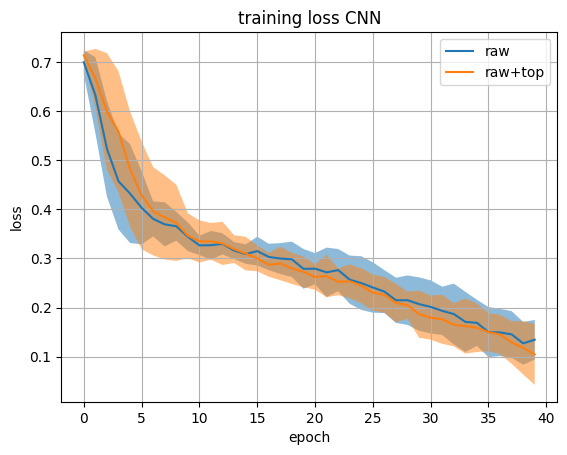

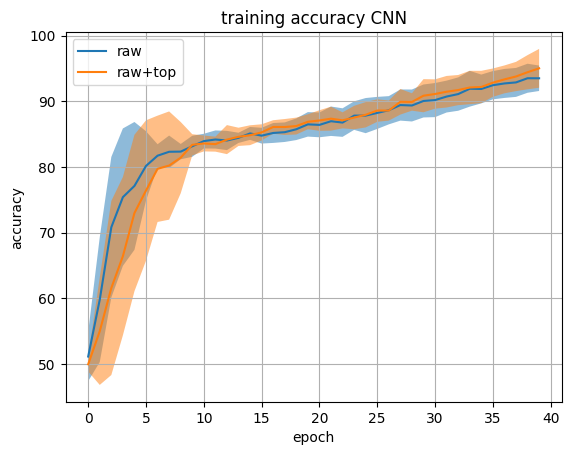

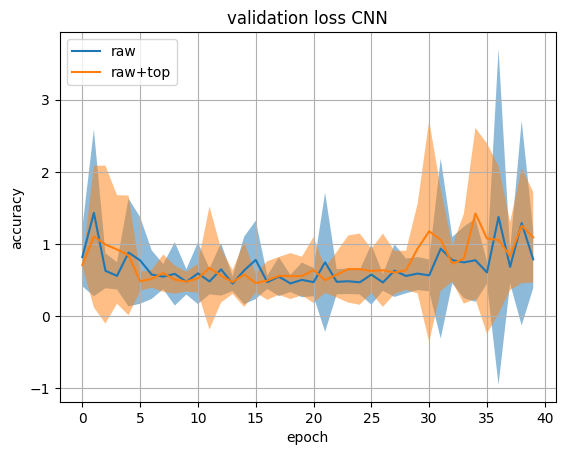

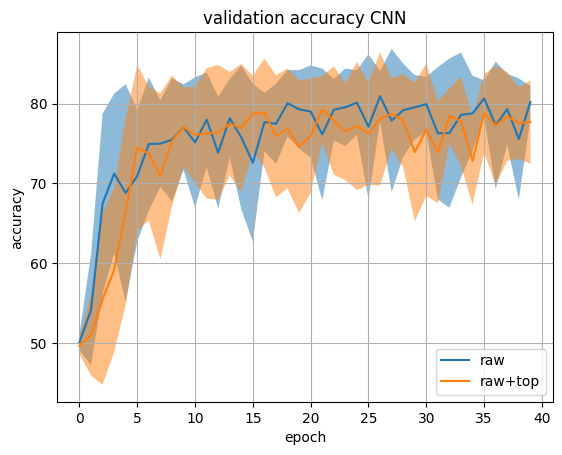

In [33]:
plot_loss([loss_cnn,loss_cnn_top], title='training loss CNN', variance=1)
plot_loss([acc_cnn,acc_cnn_top], ylabel = 'accuracy',title='training accuracy CNN', variance=1)
plot_loss([val_loss_cnn,val_loss_cnn_top], title='validation loss CNN',ylabel='accuracy', variance=1)
plot_loss([val_acc_cnn,val_acc_cnn_top],ylabel = 'accuracy',title='validation accuracy CNN', variance=1)

# CNN ROC CURVES

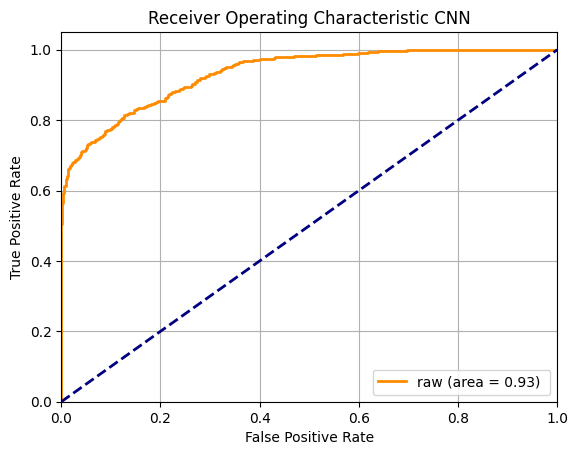

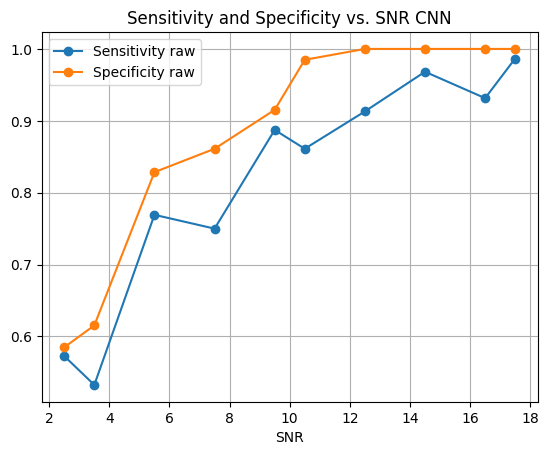

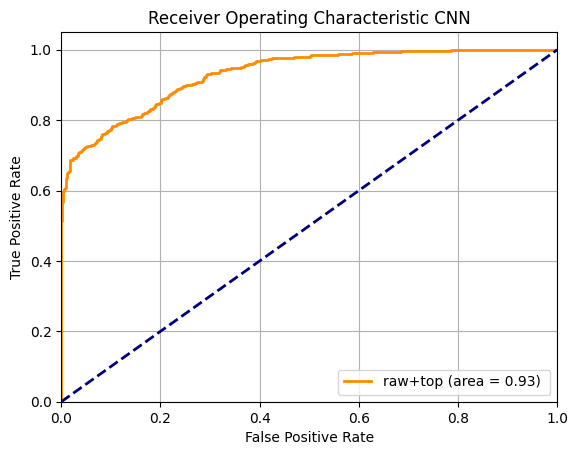

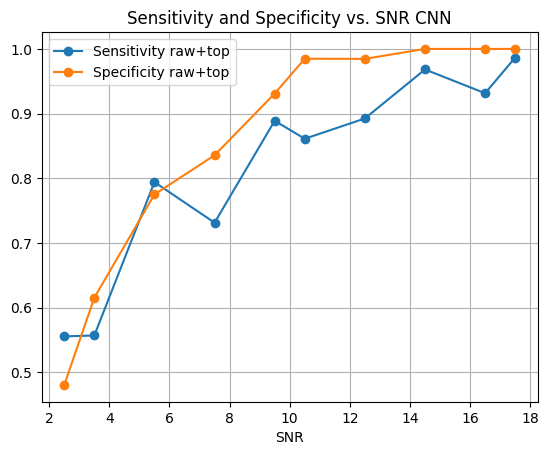

In [108]:
runs_cnn = list(np.arange(0,15))
runs_cnn_top = list(np.arange(1,10))#list(np.where(eval_cnn_top>55)[0])
#ROC CNN
y_pred, y_pred_probs,y_true, snr_values, mean_roc =  average_predictions(model_cnn, runs =runs_cnn, str= 'cnn', test_loader = test_loader)
roc_c(y_true, y_pred_probs)
sen_spec(snr_values, str='CNN', features = 'raw')
#top
y_pred, y_pred_probs,y_true, snr_values, mean_roc_top =  average_predictions(model_cnn_top, runs =runs_cnn, str= 'cnn_top', test_loader = test_loader_top)
roc_c(y_true, y_pred_probs, str='CNN', features='raw+top ')
sen_spec(snr_values, str='CNN', features = 'raw+top')

# HCNN1 LOSS AND ACCURACY

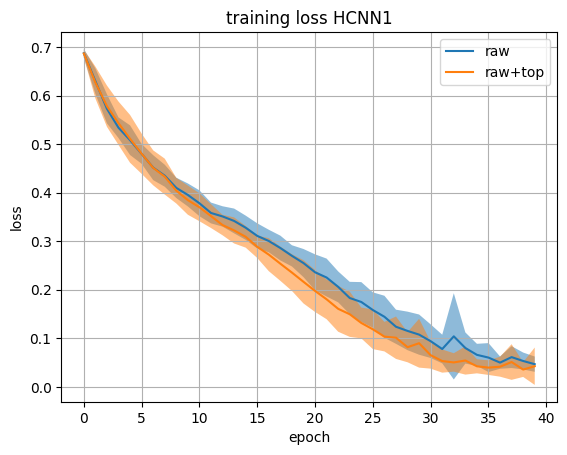

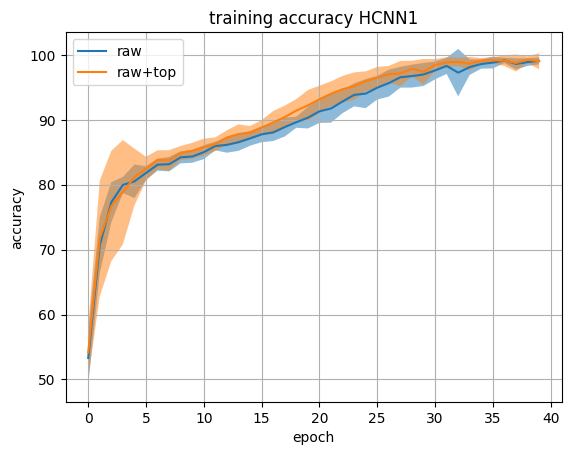

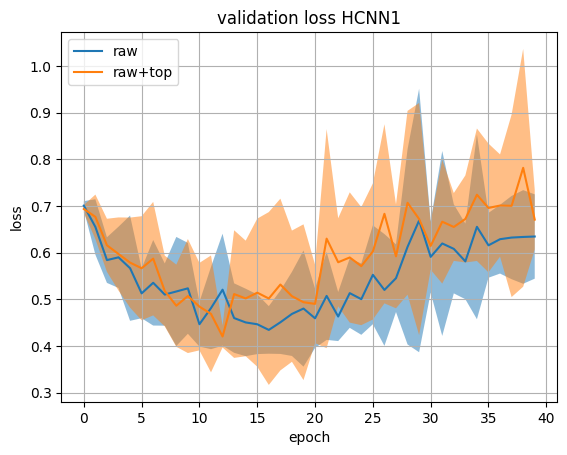

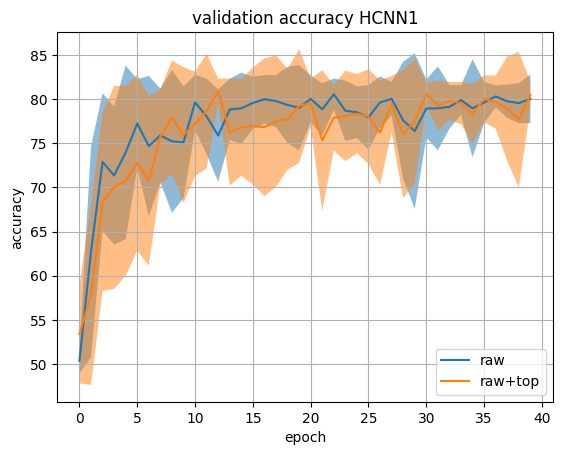

In [35]:
#HCNN1
plot_loss([loss_hcnn1,loss_hcnn1_top], title='training loss HCNN1', variance=1)
plot_loss([acc_hcnn1,acc_hcnn1_top], title='training accuracy HCNN1', ylabel='accuracy',variance=1)
plot_loss([val_loss_hcnn1,val_loss_hcnn1_top], title='validation loss HCNN1', variance=1)
plot_loss([val_acc_hcnn1,val_acc_hcnn1_top],title='validation accuracy HCNN1',ylabel='accuracy', variance=1)

# HCNN1 ROC CURVES 

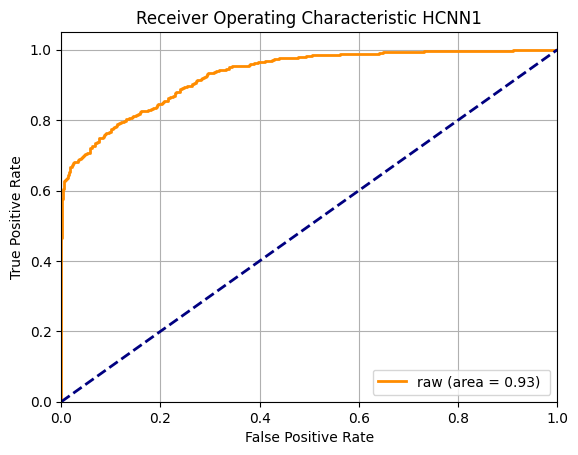

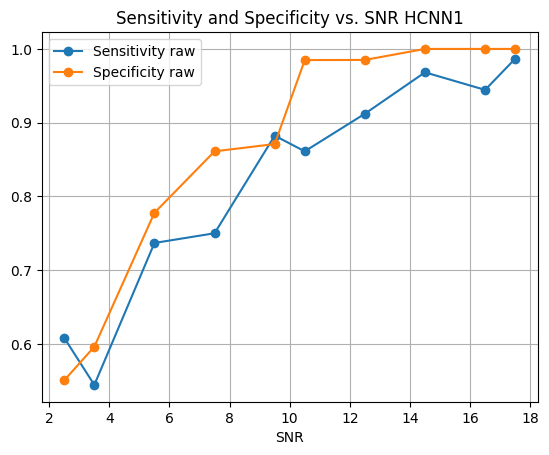

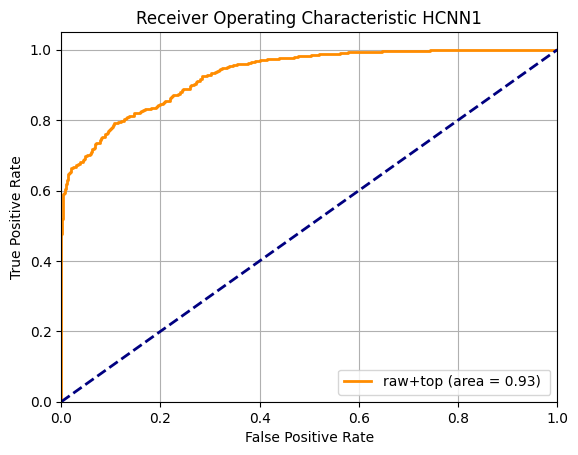

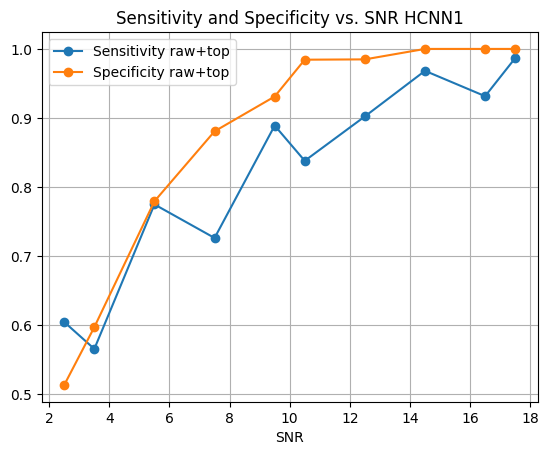

In [37]:
#ROC HCNN1
y_pred, y_pred_probs,y_true, snr_values, mean_roc_hcnn1 =  average_predictions(model_hcnn1, runs =runs_cnn, str= 'hcnn1', test_loader = test_loader)
roc_c(y_true, y_pred_probs, str='HCNN1')
sen_spec(snr_values, str='HCNN1', features = 'raw')
#top
y_pred, y_pred_probs,y_true, snr_values, mean_roc_hcnn1_top =  average_predictions(model_hcnn1_top, runs =runs_cnn, str= 'hcnn1_top', test_loader = test_loader_top)
roc_c(y_true, y_pred_probs, str='HCNN1', features='raw+top ')
sen_spec(snr_values, str='HCNN1', features = 'raw+top')

# HCNN2 LOSS AND ACCURACY

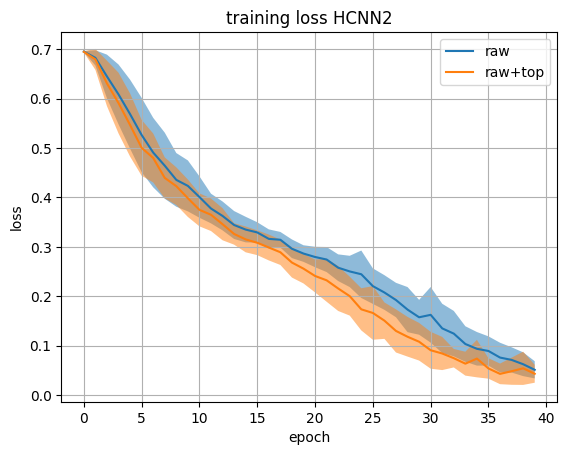

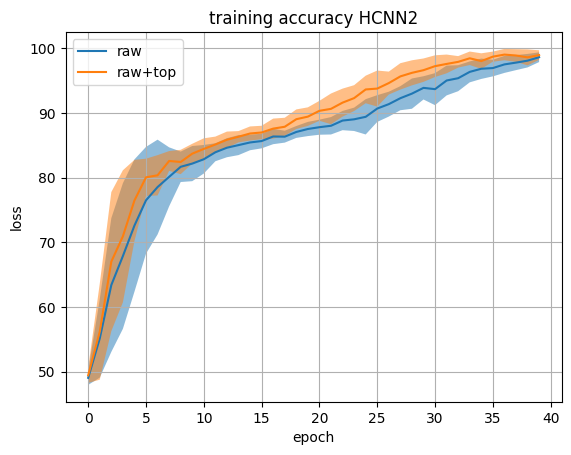

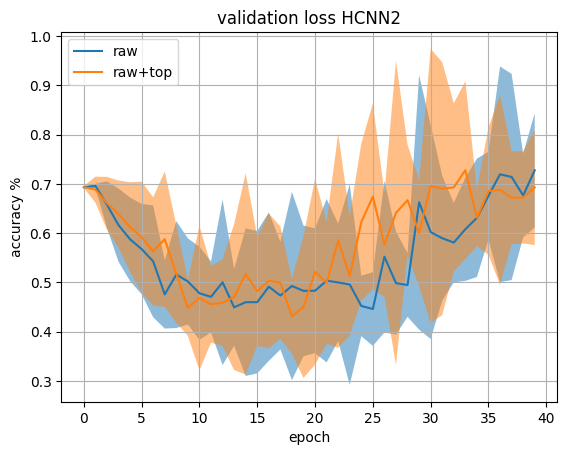

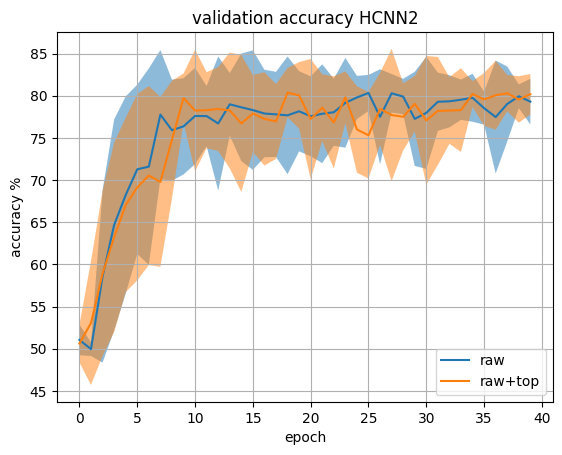

In [38]:
#HCNN2
plot_loss([loss_hcnn2,loss_hcnn2_top], title='training loss HCNN2', variance=1)
plot_loss([acc_hcnn2,acc_hcnn2_top], title='training accuracy HCNN2', variance=1)
plot_loss([val_loss_hcnn2,val_loss_hcnn2_top], title='validation loss HCNN2',ylabel='accuracy %', variance=1)
plot_loss([val_acc_hcnn2,val_acc_hcnn2_top],title='validation accuracy HCNN2',ylabel='accuracy %', variance=1)

# HCNN2 ROC CURVES

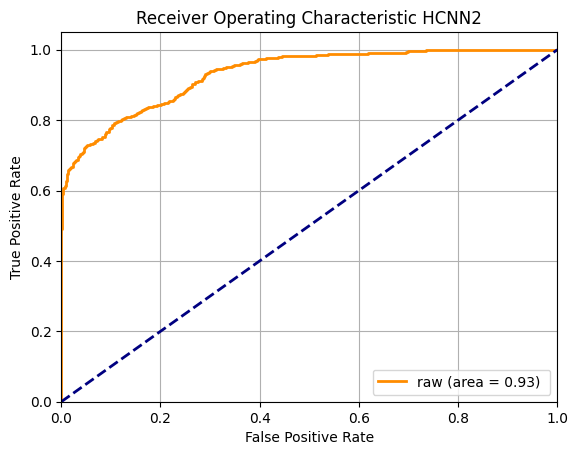

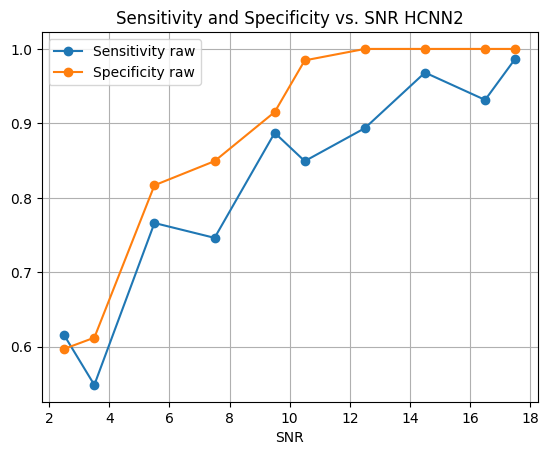

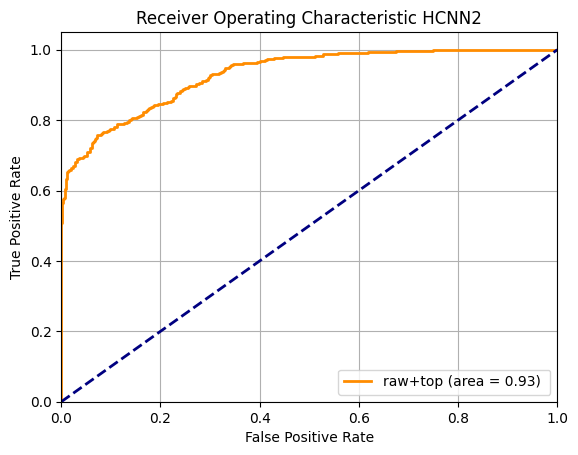

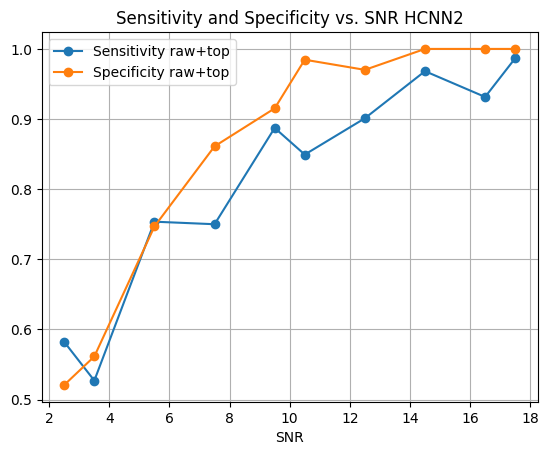

In [39]:
#ROC HCNN2
y_pred, y_pred_probs,y_true, snr_values, mean_roc_hccn2 =  average_predictions(model_hcnn2, runs =runs_cnn, str= 'hcnn2', test_loader = test_loader)
roc_c(y_true, y_pred_probs, str='HCNN2')
sen_spec(snr_values, str='HCNN2', features = 'raw')
#top
y_pred, y_pred_probs,y_true, snr_values, mean_roc_hccn2_top =  average_predictions(model_hcnn2_top, runs =runs_cnn, str= 'hcnn2_top', test_loader = test_loader_top)
roc_c(y_true, y_pred_probs, str='HCNN2', features='raw+top ')
sen_spec(snr_values, str='HCNN2', features = 'raw+top')

# WELCH'S T-TESTS

In [4]:
from scipy import stats
def welchs_ttest(model_a_performance, model_b_performance):
    
    # Convert inputs to numpy arrays if they aren't already
    model_a_performance = np.array(model_a_performance)
    model_b_performance = np.array(model_b_performance)

    # Compute the means and standard deviations
    mean_a = np.mean(model_a_performance)
    mean_b = np.mean(model_b_performance)

    std_a = np.std(model_a_performance, ddof=1)
    std_b = np.std(model_b_performance, ddof=1)

    # Print descriptive statistics
    print(f'Mean of Model A: {mean_a:.3f}, Std Dev: {std_a:.3f}')
    print(f'Mean of Model B: {mean_b:.3f}, Std Dev: {std_b:.3f}')

    # Perform Welch's t-test
    t_statistic, p_value = stats.ttest_ind(model_a_performance, model_b_performance, equal_var=True)

    # Print the t-statistic and p-value
    print(f'T-statistic: {t_statistic:.3f}')
    print(f'P-value: {p_value:.5f}')

    return t_statistic, p_value


In [2]:
#CNN
loss_cnn= torch.load( 'data_tensors/main/loss_cnn.pt')
acc_cnn=torch.load('data_tensors/main/acc_cnn.pt')
val_loss_cnn=torch.load( 'data_tensors/main/val_loss_cnn.pt')
val_acc_cnn=torch.load('data_tensors/main/val_acc_cnn.pt')
eval_cnn=torch.load( 'data_tensors/main/eval_cnn.pt')

#CNN TOP
loss_cnn_top = torch.load('data_tensors/main/loss_cnn_top.pt')
acc_cnn_top=torch.load('data_tensors/main/acc_cnn_top.pt')
val_loss_cnn_top=torch.load( 'data_tensors/main/val_loss_cnn_top.pt')
val_acc_cnn_top=torch.load( 'data_tensors/main/val_acc_cnn_top.pt')
eval_cnn_top=torch.load( 'data_tensors/main/eval_cnn_top.pt')


#HCNN1
loss_hcnn1= torch.load('data_tensors/main/loss_hcnn1.pt')
acc_hcnn1 = torch.load('data_tensors/main/acc_hcnn1.pt')
val_loss_hcnn1= torch.load( 'data_tensors/main/val_loss_hcnn1.pt')
val_acc_hcnn1=torch.load('data_tensors/main/val_acc_hcnn1.pt')
eval_hcnn1 =torch.load( 'data_tensors/main/eval_hcnn1.pt')


#HCNN1 TOP
loss_hcnn1_top= torch.load('data_tensors/main/loss_hcnn1_top.pt')
acc_hcnn1_top = torch.load('data_tensors/main/acc_hcnn1_top.pt')
val_loss_hcnn1_top= torch.load( 'data_tensors/main/val_loss_hcnn1_top.pt')
val_acc_hcnn1_top=torch.load('data_tensors/main/val_acc_hcnn1_top.pt')
eval_hcnn1_top =torch.load( 'data_tensors/main/eval_hcnn1_top.pt')

#HCNN2
loss_hcnn2= torch.load('data_tensors/main/loss_hcnn2.pt')
acc_hcnn2 = torch.load('data_tensors/main/acc_hcnn2.pt')
val_loss_hcnn2= torch.load( 'data_tensors/main/val_loss_hcnn2.pt')
val_acc_hcnn2=torch.load('data_tensors/main/val_acc_hcnn2.pt')
eval_hcnn2 =torch.load( 'data_tensors/main/eval_hcnn2.pt')


#HCNN2 TOP
loss_hcnn2_top= torch.load('data_tensors/main/loss_hcnn2_top.pt')
acc_hcnn2_top = torch.load('data_tensors/main/acc_hcnn2_top.pt')
val_loss_hcnn2_top= torch.load( 'data_tensors/main/val_loss_hcnn2_top.pt')
val_acc_hcnn2_top=torch.load('data_tensors/main/val_acc_hcnn2_top.pt')
eval_hcnn2_top =torch.load( 'data_tensors/main/eval_hcnn2_top.pt')

In [33]:
t_statistic, p_value = welchs_ttest(eval_cnn, eval_cnn_top)
t_statistic, p_value = welchs_ttest(mean_roc, mean_roc_top)


Mean of Model A: 82.705, Std Dev: 0.557
Mean of Model B: 82.243, Std Dev: 0.524
T-statistic: 2.339
P-value: 0.02671
Mean of Model A: 0.926, Std Dev: 0.003
Mean of Model B: 0.926, Std Dev: 0.003
T-statistic: 0.158
P-value: 0.87559


In [32]:

t_statistic, p_value = welchs_ttest(eval_hcnn1, eval_hcnn1_top)
t_statistic, p_value = welchs_ttest(mean_roc_hcnn1, mean_roc_hcnn1_top)


Mean of Model A: 82.800, Std Dev: 0.747
Mean of Model B: 82.438, Std Dev: 0.628
T-statistic: 1.436
P-value: 0.16207
Mean of Model A: 0.920, Std Dev: 0.006
Mean of Model B: 0.917, Std Dev: 0.013
T-statistic: 0.890
P-value: 0.38084


In [34]:
t_statistic, p_value = welchs_ttest(eval_hcnn2, eval_hcnn2_top)
t_statistic, p_value = welchs_ttest(mean_roc_hccn2, mean_roc_hccn2_top)

Mean of Model A: 82.790, Std Dev: 0.674
Mean of Model B: 82.267, Std Dev: 0.447
T-statistic: 2.509
P-value: 0.01817
Mean of Model A: 0.925, Std Dev: 0.008
Mean of Model B: 0.920, Std Dev: 0.011
T-statistic: 1.250
P-value: 0.22157
